In [1]:
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier

np.random.seed(42)
dataset = pd.read_csv('HotDataset.csv')

In [2]:
bins = [0, 10, 20, 30, 40]
labels = ['Very low', 'Low', 'Moderate', 'High']
dataset['Mental health category'] = pd.cut(dataset['Mental health score'], bins=bins, labels=labels)

X = dataset.drop(['Mental health score', 'Mental health category'], axis=1) # X is the feature
y = dataset['Mental health category'] # y is the target variable

# This piece of code is common with Naive_Bayes.ipynb

In [3]:
le = LabelEncoder()
y = le.fit_transform(y)
# Encoded a unique value to the categories, such that
# 0 - [Zero Category]
# 1 - [Very Low 0-10]
# 2 - [Low 10-20]
# 3 - [Moderate 20-30]
# 4 - [High 30-40]

# Split the dataset into train, test and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
# Splitting test set in half, one half remains in test set and the other goes to the validation set

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    # SimpleImputer replaces all missing values with the median
    ('scaler', StandardScaler())])
    # StandardScaler makes each feature have a standard deviation of 1 and a mean of 0

    # NOTE: StandardScaler does not modify the data, it only transforms it to be easier to read by a Machine Learning model.
    # This means the data sent into the model is the exact same as the dataset, only its been standardized
    # More info on https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # This instance of SimpleImputer replaces missing values with the one that appears most frequently
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    # Performs OneHotEncoding on categorical values in X
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, X.select_dtypes(include=['int64', 'float64']).columns),
        ('cat', categorical_transformer, X.select_dtypes(include=['object']).columns)
    ]
)

# This piece of code is common with Naive_Bayes.ipynb

In [4]:
pipeline_mlp = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', MLPClassifier(random_state=42))])

param_grid = {
    'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)], # 4 combinations
    'classifier__activation': ['relu', 'tanh'], # 2 combinations
    'classifier__alpha': [0.0001, 0.001, 0.01], # 3 Combinations
    'classifier__learning_rate': ['constant', 'adaptive'], # 2 Combinations
}
# 4*2*3*2 = 48
# There are 48 possible combinations for hyperparameters

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    # Ignoring warnings that could make the logs unreadable, mainly ConvergenceWarning
    grid_search = GridSearchCV(pipeline_mlp, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

best_mlp_model = grid_search.best_estimator_
# best_estimator_ is a new estimator which the GridSearch found gave the highest scores
print("Best Parameters:", grid_search.best_params_)
# Best Params should be
#'classifier__activation': 'tanh',
#'classifier__alpha': 0.0001,
#'classifier__hidden_layer_sizes': (50, 50),
#'classifier__learning_rate': 'constant'

Best Parameters: {'classifier__activation': 'tanh', 'classifier__alpha': 0.0001, 'classifier__hidden_layer_sizes': (50, 50), 'classifier__learning_rate': 'constant'}


In [5]:
y_pred_mlp = best_mlp_model.predict(X_test)
accuracy_mlp = accuracy_score(y_test, y_pred_mlp) * 100
print("MLP Classifier Testing Set Metrics:")
print("Accuracy: ", accuracy_mlp, "%", sep="")

MLP Classifier Testing Set Metrics:
Accuracy: 95.50561797752809%


In [6]:
y_pred_mlp_valid = best_mlp_model.predict(X_valid)
accuracy_mlp_valid = accuracy_score(y_valid, y_pred_mlp_valid) * 100
print("MLP Classifier Validation Set Metrics:")
print("Accuracy: ", accuracy_mlp_valid, "%", sep="")

MLP Classifier Validation Set Metrics:
Accuracy: 96.66666666666667%


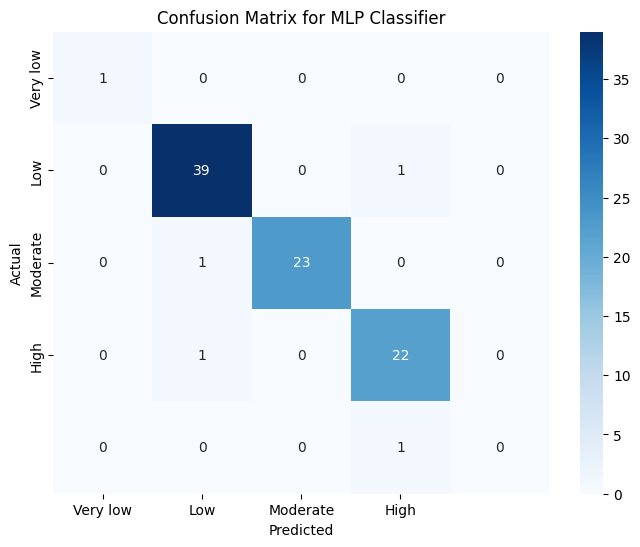

In [7]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_mlp)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for MLP Classifier')
plt.show()

In [8]:
print("Classification Report for MLP Classifier:")
labels = ['Zero Category', 'Very Low', 'Low', 'Moderate', 'High']
print(classification_report(y_test, y_pred_mlp, target_names=labels))

Classification Report for MLP Classifier:
               precision    recall  f1-score   support

Zero Category       1.00      1.00      1.00         1
     Very Low       0.95      0.97      0.96        40
          Low       1.00      0.96      0.98        24
     Moderate       0.92      0.96      0.94        23
         High       0.00      0.00      0.00         1

     accuracy                           0.96        89
    macro avg       0.77      0.78      0.78        89
 weighted avg       0.95      0.96      0.95        89



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Average BPM for each mental health category:
Mental health category
Very low    118.622047
Low         123.942149
Moderate    125.716495
High        121.166667
Name: BPM, dtype: float64
Correlation between BPM & Mental Health Score: 0.06858666274887795
There is a positive correlation between BPM and mental health.


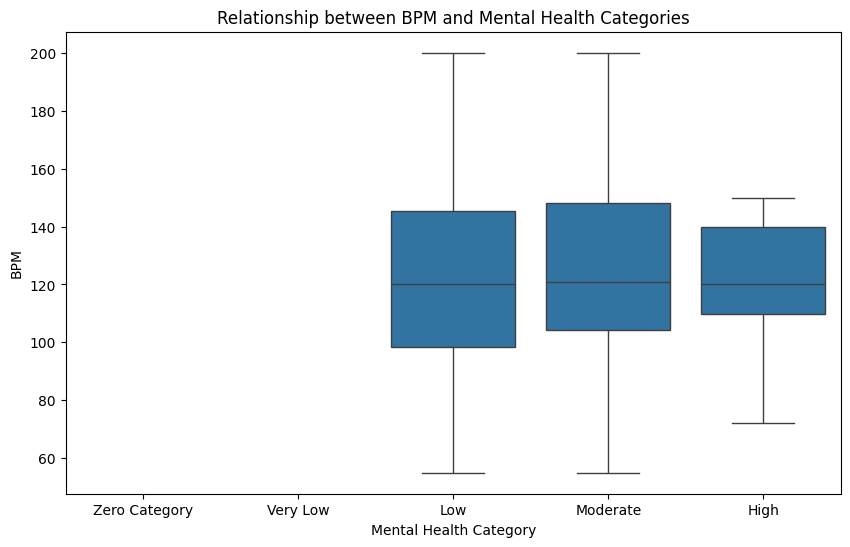

In [10]:
# OLAP Q.7:
# How does the BPM of music relate to the mental health of individuals?
# Are there specific ranges of BPM associated with lower (or higher) levels of mental health issues?

bpm_by_category = dataset.groupby('Mental health category')['BPM'].mean()

print("Average BPM for each mental health category:")
print(bpm_by_category)

correlation = dataset['BPM'].corr(dataset['Mental health score'])
print("Correlation between BPM & Mental Health Score:",correlation)
if correlation > 0:
    print("There is a positive correlation between BPM and mental health.")
elif correlation < 0:
    print("There is a negative correlation between BPM and mental health.")
else:
    print("There is no significant correlation between BPM and mental health.")

plt.figure(figsize=(10, 6))
sns.boxplot(x='Mental health category', y='BPM', data=dataset, order=labels)
plt.title('Relationship between BPM and Mental Health Categories')
plt.xlabel('Mental Health Category')
plt.ylabel('BPM')
plt.show()